# Tutorial4: Synthesizing EHT observations
---
This tutorial demonstrates how to synthesize EHT VLBI observations from videos. This requires use of `eht-imaging`.

In [1]:
import pynoisy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

Welcome to eht-imaging! v 1.1.1 



In [3]:
"""
Generate a stochastic video by modulating an envelope with a Gaussian Random Field. 
Set the field of view (fov) of the video to 160.0 [uas].
"""
diffusion = pynoisy.diffusion.general_xy(nx=64, ny=64)
advection = pynoisy.advection.general_xy(nx=64, ny=64)
solver = pynoisy.forward.HGRFSolver(advection, diffusion, nt=64)
grf = solver.run()

# Use the GRF to modulate an envelope and generate a video with pixels as flux densities 
fov = (160.0, 'uas')
envelope = pynoisy.envelope.ring(nx=64, ny=64).image.set_fov(fov)
grf = grf.image.set_fov(fov)

alpha = 2.0
movie = pynoisy.forward.modulate(envelope, grf, alpha)

<IPython.core.display.Javascript object>


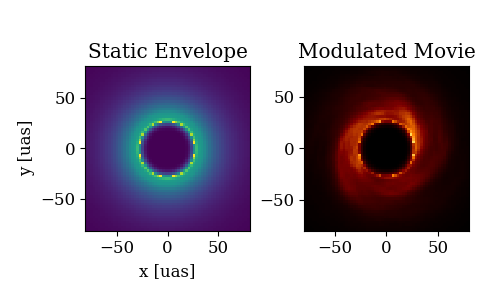

In [9]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(5,3))
envelope.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('Static Envelope')
ax[1].set_title('Modulated Movie')
ax[0].set_aspect('equal')
plt.tight_layout()
movie.visualization.animate(ax=ax[1], add_colorbar=False, cmap='afmhot')